### Function definitions

In [2]:
from multiprocessing import Process
from urllib import urlopen
from time import sleep

UPDATE_INTERVAL = 0.3

class URLThread(Process):
    def __init__(self,url):
        super(URLThread, self).__init__()
        self.url = url
        self.response = None

    def run(self):
        self.request = urlopen(self.url)
        self.response = self.request.read()

def multi_get(uris,timeout=2.0):
    def alive_count(lst):
        alive = map(lambda x : 1 if x.is_alive() else 0, lst)
        return reduce(lambda a,b : a + b, alive)
    threads = [ URLThread(uri) for uri in uris ]
    for thread in threads:
        thread.start()
    while alive_count(threads) > 0 and timeout > 0.0:
        timeout = timeout - UPDATE_INTERVAL
        sleep(UPDATE_INTERVAL)
    for thread in threads:
        thread.join()
    return [ (x.url, x.response) for x in threads ]

### Cache the data from a specified set of netCDF files
#### Request only one tile from every zoom level to cache all zoom levels

In [54]:
import os
from netCDF4 import Dataset as ncDataset

# granule = 'S1A_EW_GRDM_1SDH_20141003T183449_20141003T183553_002669_002F93_5A6D'

# pn = '/media/SOLabNFS2/store/satellite/SOLAB-SENTINEL-1/2014/10/03/'
pn = '/nfs1/store/nctiles/SOLAB_ASAR/epsg_3413/2012/'

# granule_list = listdir(pn)
granule_list = [os.path.join(dn,fn) for dn,_,fns in os.walk(pn) for fn in fns if fn.endswith('.nc')]

# product = 'SOLAB-SENTINEL-1'
product = 'SOLAB_ASAR'
var_list = ['sigma0']

urls = []
coords = []

print "Total number of files: %s" %len(granule_list)
for granule in granule_list:
    dataset = ncDataset(granule)
    try:
        p = dataset.polarizations
    except Exception as e:
        p = 'vv'
    coords = dataset.variables['Data'].shape
    for var in var_list:
        for zoom in range(coords[2]):
            urls.append(
                'http://10.170.0.153:9090/wms?' +
                'product=' + product +
                '&variable=' + var +
                '&granule=' + granule[-62:-3] +
                '&projection=EPSG%3A3413' +
                '&polarization=' + str(p) +
                '&vmin=63&vmax=191&' +
                'zoom=' + str(zoom) +
                '&x=' + str(0) +
                '&y=' + str(0))
    dataset.close()
urls.sort()

print "Total number of zoom-level requests: %s" %len(urls)

Total number of files: 27
Total number of zoom-level requests: 199


In [55]:
%%timeit -r 1 -n 1
requests = multi_get(urls,timeout=1)
# for url, data in requests:
#     print "received from this url \n%s" % (url)

Process URLThread-3:
Process URLThread-2:
Process URLThread-1:
Process URLThread-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "<ipython-input-2-72ba71fb1416>", line 14, in run
  File "<ipython-input-2-72ba71fb1416>", line 14, in run
  File "<ipython-input-2-72ba71fb1416>", line 14, in run
    self.request = urlopen(self.url)
    self.request = urlopen(self.url)
    self.request = urlopen(self.url)
  File "/usr/lib/python2.7/urllib.py", line 87, in urlopen
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/urllib.py", line 87, in urlopen
Process URL

1 loops, best of 1: 2.1 s per loop


IOError: ('http protocol error', 0, 'got a bad status line', None)
Process URLThread-197:
    self.request = urlopen(self.url)
Process URLThread-198:
Process URLThread-199:
  File "/usr/lib/python2.7/urllib.py", line 87, in urlopen
Traceback (most recent call last):
Traceback (most recent call last):
    return opener.open(url)
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/urllib.py", line 208, in open
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    return getattr(self, name)(url)
    self.run()
  File "<ipython-input-2-72ba71fb1416>", line 14, in run
  File "<ipython-input-2-72ba71fb1416>", line 14, in run
  File "/usr/lib/python2.7/urllib.py", line 352, in open_http
  File "<ipython-input-2-72ba71fb1416>", line 14, in run
    self.request = urlop

In [ ]:
%%timeit -r 100 -n 10
request = urlopen(urls[3])

In [57]:
import redis
r = redis.Redis(host='10.170.0.153', password='jM8vBgR4', db=0)
r.dbsize()
# r.flushall()

31737L

In [51]:
%%timeit
try:
    dataset = ncDataset(granule)
except:
    err_message = 'Cannot open dataset:' 

coords = dataset.variables['Data'].shape

# print var_number, polarization_index, zoom

# First cache the requested zoom level
for x in range(coords[3]):
    for y in range(coords[4]):
        body = dataset.variables['Data'][0, 0, 5, x, y, :]
        # don't cache empty tile
        if body.mean() == 255:
            continue

if dataset.isopen():
    dataset.close()

1 loops, best of 3: 5.41 s per loop


In [5]:
r.keys('*lock')

[]

In [6]:
r.dbsize()

31324L

In [ ]:
r.flushall()

In [ ]:
import redis
r = redis.Redis(host='posada.solab.rshu.ru', password='jM8vBgR4', db=0)
r.dbsize()
# r.flushdb()

In [ ]:
import random

granule = 'S1A_EW_GRDM_1SDH_20141003T183449_20141003T183553_002669_002F93_5A6D'

var_list = ['sigma0w', 'wind_speed']

urls = ['http://10.170.0.153:9090/wms?product=SOLAB-SENTINEL-1&' +
        'variable=' + var_list[random.randint(0,1)] +
        '&granule=' + granule +
        '&projection=EPSG%3A3413&polarization=hh&vmin=63&vmax=191&zoom=0&x=0&y=0']

for x in xrange(0,10**2):
    urls.append(
        'http://10.170.0.153:9090/wms?product=SOLAB-SENTINEL-1&' +
        'variable=' + var_list[random.randint(0,1)] +
        '&granule=' + granule +
        '&projection=EPSG%3A3413&polarization=hh&vmin=63&vmax=191&'
        'zoom=' + str(random.randint(0,5)) +
        '&x=' + str(random.randint(0,2)) +
        '&y=' + str(random.randint(0,2)))
print len(urls)

In [ ]:
%%timeit -r 1
for u in urls:
    request = urlopen(u)

### Checking that "EVAL" takes 3 times longer than "split" and "map"

In [ ]:
import redis
import numpy as np
r = redis.Redis(host='10.170.0.153', password='jM8vBgR4', db=0)
body = None

In [ ]:
def str2float(List):
    return map(float, List)

In [ ]:
%%timeit
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/1'
body = r.get(tilekey)
body = [s.split(', ') for s in body[2:-2].split('], [')]
body = map(str2float, body)
body = np.asarray(body)
body = np.ma.masked_equal(body, None)

In [ ]:
%%timeit
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/1'
body = r.get(tilekey)
body = [s.split(', ') for s in body[2:-2].split('], [')]
body = [[float(i) for i in row] for row in body]
body = np.asarray(body)
body = np.ma.masked_equal(body, None)

In [ ]:
%%timeit
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/1'
body = r.get(tilekey)
body = np.array(eval(body))

In [2]:
%matplotlib inline

In [3]:
from pylab import *

In [7]:
import numpy as np
from PIL import Image
from numpy.random import random as randomArray
from io import BytesIO


array = np.ma.array(randomArray((256,256))*255, np.uint8)

In [112]:
vmin=61
vmax=191

# vmin=0
# vmax=254

bufPIL = BytesIO()
# img = Image.fromarray(array).convert("L", colors=256)
# array = np.array(randomArray((256,256))*255, np.uint8)

array = np.ma.asarray(Image.open('empire.jpg').convert('L'), np.uint8)
# Normalize image in the ``[vmin, vmax]`` interval
if vmin == vmax:
    array.fill(0)   # Or should it be all masked?  Or 0.5?
elif vmin > vmax:
    err_message = "vmin value must be less than or equal to vmax value"
    self.get_return_message(err_message, 400)
else:
    vmin = float(vmin)
    vmax = float(vmax)

# mask = ma.getmask(ma.masked_equal(array, uint8(255)))
# array = ma.array(clip(array.filled(vmax), vmin, vmax),
#                                   mask=mask)

# # ma division is very slow; we can take a shortcut
# resdat = array.data
# resdat -= vmin
# resdat /= (vmax - vmin)
# resdat *= 254
# array = np.ma.array(resdat, mask=mask, copy=False)

mask = array==255
array = np.array(clip(array, vmin, vmax))

# ma divisionand other operations are very slow; we can take a shortcut
array -= vmin
array /= (vmax - vmin)
array *= 254
array[mask] = 255
array = uint8(array)


img = Image.fromarray(array).convert("L", colors=256)

# img = Image.fromarray(matplotlib.pylab.plt.cm.jet(array, bytes=True)).convert("L", colors=256)
img.save(bufPIL, format='png')
bufPIL.seek(0)
contentPIL = bufPIL.getvalue()
bufPIL.close()

bufPIL = BytesIO(contentPIL)
bodyPIL = np.asarray(Image.open(bufPIL), np.uint8)
# bodyPIL = np.ma.masked_equal(bodyPIL, 255)
# bodyPIL =  np.ma.masked_where(bodyPIL == 255, bodyPIL)

In [115]:
bodyPIL

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 254, 254, ..., 255, 255,   0],
       [  0, 254, 254, ..., 254, 255,   0],
       ..., 
       [  0, 254, 254, ..., 255, 255,   0],
       [  0, 254, 254, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [113]:
array

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 254, 254, ..., 255, 255,   0],
       [  0, 254, 254, ..., 254, 255,   0],
       ..., 
       [  0, 254, 254, ..., 255, 255,   0],
       [  0, 254, 254, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [116]:
array = np.ma.asarray(Image.open('empire.jpg').convert('L'), np.uint8)

In [95]:
%%timeit

array = np.ma.asarray(Image.open('empire.jpg').convert('L'), np.uint8)

mask = ma.getmask(ma.masked_equal(array, uint8(255)))
array = ma.array(clip(array.filled(vmax), vmin, vmax),
                                  mask=mask)

# ma division is very slow; we can take a shortcut
resdat = array.data
resdat -= vmin
resdat /= (vmax - vmin)
resdat *= 254
array = np.ma.array(resdat, mask=mask, copy=False)


100 loops, best of 3: 7.7 ms per loop


In [103]:
%%timeit

array = np.asarray(Image.open('empire.jpg').convert('L'), np.uint8)
mask = array==255
array = np.array(clip(array, vmin, vmax))

# ma division is very slow; we can take a shortcut
array -= vmin
array /= (vmax - vmin)
array *= 254
array[mask] = 255

100 loops, best of 3: 6.32 ms per loop


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 254, 254, ..., 255, 255,   0],
       [  0, 254, 254, ..., 254, 255,   0],
       ..., 
       [  0, 254, 254, ..., 255, 255,   0],
       [  0, 254, 254, ..., 255, 255,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

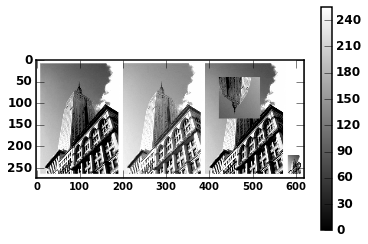

In [104]:
imshow(array)
colorbar()
gray()

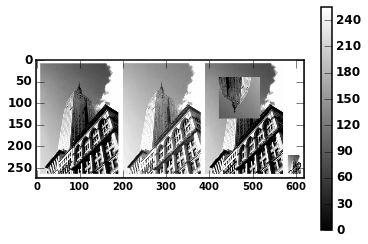

In [114]:
imshow(bodyPIL)
colorbar()
gray()

### Image caching speed

In [79]:
import redis
import numpy as np
r = redis.Redis(host='10.170.0.153', password='jM8vBgR4', db=0)

In [8]:
import matplotlib
from matplotlib.pylab import gray, imsave, jet
matplotlib.use('Agg')
from io import BytesIO
vmin=0
vmax=254
from numpy.random import random as randomArray

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#### matplotlib

In [81]:
from matplotlib import image

In [82]:
%%timeit

buf = BytesIO()
imsave(buf, array, vmin=vmin, vmax=vmax, format='png')
buf.seek(0)
content = buf.getvalue()
buf.close()

tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/0'
r.setex(tilekey, content, 24*60*60)
content = r.get(tilekey)

10 loops, best of 3: 41.8 ms per loop


In [75]:
# %%timeit

buf = BytesIO(content)
body = np.array(image.imread(buf), np.uint8)
body = np.ma.masked_equal(body, 255)

NameError: name 'content' is not defined

#### pillow

In [83]:
from PIL import Image

In [ ]:
%%timeit -r 10
bodyPIL = np.array(Image.open(bufPIL), np.uint8)

In [ ]:
%%timeit -r 10
bodyPIL = np.asarray(Image.open(bufPIL), np.uint8)

In [ ]:
%%timeit -r 20
img = Image.fromarray(np.uint8(matplotlib.pylab.plt.cm.jet(array)*255)).convert("L", colors=256)

In [ ]:
%%timeit -r 20
img = Image.fromarray(matplotlib.pylab.plt.cm.jet(array, bytes=True)).convert("L", colors=256)

In [99]:
array == 255

False

In [38]:
from numpy import ma, clip
array_ = (randomArray((256,256))*255)

In [39]:
%%timeit
array = np.ma.asarray(array_, np.uint8)
if type(array) == np.ma.core.MaskedArray:
    mask = ma.getmask(array)
else:
    mask = array==255
array = np.array(clip(array, vmin, vmax))

1000 loops, best of 3: 170 µs per loop


In [40]:
array = array_.copy()

In [42]:
%%timeit
array = np.asarray(array_, np.uint8)
if type(array) == np.ma.core.MaskedArray:
    mask = ma.getmask(array)
else:
    mask = array==255
array = np.array(clip(array, vmin, vmax))

10000 loops, best of 3: 118 µs per loop


In [1]:
%%timeit -r 3

vmin=0
vmax=254
array = np.ma.asarray(randomArray((256,256))*255, np.uint8)
# Normalize image in the ``[vmin, vmax]`` interval
if vmin == vmax:
    array.fill(0)   # Or should it be all masked?  Or 0.5?
elif vmin > vmax:
    err_message = "vmin value must be less than or equal to vmax value"
    self.get_return_message(err_message, 400)
else:
    vmin = float(vmin)
    vmax = float(vmax)

mask = ma.getmask(ma.masked_equal(array, uint8(255)))
array = ma.array(clip(array.filled(vmax), vmin, vmax),
                                  mask=mask)

# ma division is very slow; we can take a shortcut
resdat = array.data
resdat -= vmin
resdat /= (vmax - vmin)
resdat *= 255
array = np.ma.array(resdat, mask=array.mask, copy=False)


bufPIL = BytesIO()
img = Image.fromarray(array).convert("L", colors=256)
# img = Image.fromarray(matplotlib.pylab.plt.cm.jet(array, bytes=True)).convert("L", colors=256)
img.save(bufPIL, format='png', vmin=vmin, vmax=vmax)
bufPIL.seek(0)
contentPIL = bufPIL.getvalue()
bufPIL.close()

tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/0-PIL'
r.setex(tilekey, contentPIL, 24*60*60)
contentPIL = r.get(tilekey)

bufPIL = BytesIO(contentPIL)
bodyPIL = np.asarray(Image.open(bufPIL), np.uint8)
# bodyPIL = np.ma.masked_equal(bodyPIL, 255)
bodyPIL =  np.ma.masked_where(bodyPIL == 255, bodyPIL)

NameError: global name 'np' is not defined

In [ ]:
%%timeit -r 10
np.ma.masked_equal(array, 18)

In [ ]:
%%timeit -r 10
np.ma.masked_where(array == 18, array)

#### Pickle

In [ ]:
import pickle

In [ ]:
%%timeit -r 20

contentPickle = pickle.dumps(array)
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/0-Pickle'
r.setex(tilekey, contentPickle, 24*60*60)

bufPIL = BytesIO()
img = Image.fromarray(array).convert("RGBA", colors=256)
img.save(bufPIL, format='png', vmin=vmin, vmax=vmax)
bufPIL.seek(0)
contentPIL = bufPIL.getvalue()
bufPIL.close()

bodyPickle = pickle.loads(r.get(tilekey))
bodyPickle = np.ma.masked_equal(bodyPIL, 255)

#### cPickle

In [ ]:
import cPickle

In [ ]:
%%timeit -r 20

contentPickle = cPickle.dumps(array)
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T102452_20141003T102553_002664_002F76_F611/2/0/0/0/0-cPickle'
r.setex(tilekey, contentPickle, 24*60*60)

bufPIL = BytesIO()
img = Image.fromarray(array).convert("RGBA", colors=256)
img.save(bufPIL, format='png', vmin=vmin, vmax=vmax)
bufPIL.seek(0)
contentPIL = bufPIL.getvalue()
bufPIL.close()

bodyPickle = cPickle.loads(r.get(tilekey))
bodyPickle = np.ma.masked_equal(bodyPIL, 255)

### Checking cache reading

In [ ]:
import numpy as np
from io import BytesIO
from PIL import Image


tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T233901_20141003T234005_002672_002FA5_F1D1/2/0/0/1/0/gray'
contentPIL = r.get(tilekey)
bufPIL = BytesIO(contentPIL)
bodyPIL = np.asarray(Image.open(bufPIL), np.uint8)
bodyPIL =  np.ma.masked_where(bodyPIL == 255, bodyPIL)
Image.open(bufPIL)

In [ ]:
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T233901_20141003T234005_002672_002FA5_F1D1/2/0/0/1/0/jet'
contentPIL = r.get(tilekey)
bufPIL = BytesIO(contentPIL)
bodyPIL = np.asarray(Image.open(bufPIL), np.uint8)
bodyPIL =  np.ma.masked_where(bodyPIL == 255, bodyPIL)
Image.open(bufPIL)

In [ ]:
tilekey = 'SOLAB-SENTINEL-1/S1A_EW_GRDH_1SDH_20141003T233901_20141003T234005_002672_002FA5_F1D1/2/0/0/0/0/gray'
contentPIL = r.get(tilekey)
bufPIL = BytesIO(contentPIL)
bodyPIL = np.asarray(Image.open(bufPIL), np.uint8)
bodyPIL =  np.ma.masked_where(bodyPIL == 255, bodyPIL)
Image.open(bufPIL)

IF no granule in ZOOM level => don't read data from disk => put an empty key into cache
No better to open NC file first and then to cache only needed tiles: Z/X/Y

In [ ]:
from netCDF4 import Dataset as ncDataset
nc_path = '/media/SOLabNFS2/store/satellite/SOLAB-SENTINEL-1/2014/10/03//S1A_EW_GRDH_1SDH_20141003T233901_20141003T234005_002672_002FA5_F1D1.nc'
dataset = ncDataset(nc_path)

body = dataset.variables['Data']

In [ ]:
body

In [ ]:
body.shape

### Cache multiple tiles specified by bbox

In [ ]:
from ModestMaps.Core import Coordinate
from ModestMaps.Geo import Location
from ModestMaps.OpenStreetMap import Provider

def generateCoordinates(bbox, zooms):
    """ Generate a stream of coordinates for seeding.
    
        Flood-fill coordinates based on two corners, a list of zooms.
        
    """
    
    lat1, lon1, lat2, lon2 = bbox
    south, west = min(lat1, lat2), min(lon1, lon2)
    north, east = max(lat1, lat2), max(lon1, lon2)

    northwest = Location(north, west)
    southeast = Location(south, east)
 
    osm = Provider()

    ul = osm.locationCoordinate(northwest)
    lr = osm.locationCoordinate(southeast)

    # start with a simple total of all the coordinates we will need.
    count = 0
    
    for zoom in zooms:
        ul_ = ul.zoomTo(zoom).container().left().up()
        lr_ = lr.zoomTo(zoom).container().right().down()
        
        rows = lr_.row + 1 - ul_.row
        cols = lr_.column + 1 - ul_.column
        
        count += int(rows * cols)

    # now generate the actual coordinates.
    # offset starts at zero
    offset = 0
    
    for zoom in zooms:
        ul_ = ul.zoomTo(zoom).container().left().up()
        lr_ = lr.zoomTo(zoom).container().right().down()

        for row in range(int(ul_.row), int(lr_.row + 1)):
            for column in range(int(ul_.column), int(lr_.column + 1)):
                coord = Coordinate(row, column, zoom)
                
                yield coord
                offset += 1

In [ ]:
from os import listdir

# granule = 'S1A_EW_GRDM_1SDH_20141003T183449_20141003T183553_002669_002F93_5A6D'

pn = '/media/SOLabNFS2/store/satellite/SOLAB-SENTINEL-1/2014/10/03/'
# granule_list = listdir(pn)
granule_list = {listdir(pn)[1]}

bbox = [35, -50, 80, 180]
zooms = [0,1,2,3,4,5,6]

var_list = ['sigma0w', 'wind_speed']

urls = []

if isinstance(zooms[0], str):
    for (i, zoom) in enumerate(zooms):
        if not zoom.isdigit():
            raise KnownUnknown('"%s" is not a valid numeric zoom level.' % zoom)

        zooms[i] = int(zoom)

coords = []
coordinates = generateCoordinates(bbox, zooms)
# List coordinates with one Z/X/Y coordinate per line.
for coord in coordinates:
    if coord.__dict__['column'] > 0 and coord.__dict__['row'] > 0:
        coords.append('zoom=' + str(coord.__dict__['zoom']) + 
                      '&x='   + str(coord.__dict__['column']) +
                      '&y='   + str(coord.__dict__['row']))

for granule in granule_list:
    for var in var_list:
        for coord in coords:
            urls.append(
                'http://10.170.0.153:9090/wms?product=SOLAB-SENTINEL-1&' +
                'variable=' + var +
                '&granule=' + granule[:-3] +
                '&projection=EPSG%3A3413&polarization=hh&vmin=63&vmax=191&' +
                 coord)
urls.sort()

print len(urls)
# print urls

In [ ]:
%%timeit -r 1
requests = multi_get(urls,timeout=1)
# for url, data in requests:
#     print "received from this url \n%s" % (url)

### Playing with coords

In [ ]:
bbox = [35, -50, 80, 180]
zooms = ['0', '1']

for (i, zoom) in enumerate(zooms):
    if not zoom.isdigit():
        raise KnownUnknown('"%s" is not a valid numeric zoom level.' % zoom)

    zooms[i] = int(zoom)

coordinates = generateCoordinates(bbox, zooms)
coords = []
# List coordinates with one Z/X/Y coordinate per line.
for coord in coordinates:
#     print '%(zoom)d/%(column)d/%(row)d' % coord.__dict__
#     print str(coord.__dict__['zoom']) + '/' + str(coord.__dict__['column']) + '/' + str(coord.__dict__['row'])
    if coord.__dict__['column'] > 0 and coord.__dict__['row'] >0:
        coords.append('zoom=' + str(coord.__dict__['zoom']) + 
                      '&x='   + str(coord.__dict__['column']) +
                      '&y='   + str(coord.__dict__['row']))
coords

#### Request every tile

In [ ]:
from os import listdir
from netCDF4 import Dataset as ncDataset

# granule = 'S1A_EW_GRDM_1SDH_20141003T183449_20141003T183553_002669_002F93_5A6D'

pn = '/media/SOLabNFS2/store/satellite/SOLAB-SENTINEL-1/2014/10/03/'

granule_list = listdir(pn)
# granule_list = {listdir(pn)[1]}

var_list = ['sigma0w', 'wind_speed']
urls = []
coords = []

for granule in granule_list:
    dataset = ncDataset(pn + granule)
    coords = dataset.variables['Data'].shape
    for var in var_list:
        for zoom in range(coords[2]):
            for x in range(coords[3]):
                for y in range(coords[4]):
                    urls.append(
                        'http://10.170.0.153:9090/wms?product=SOLAB-SENTINEL-1&' +
                        'variable=' + var +
                        '&granule=' + granule[:-3] +
                        '&projection=EPSG%3A3413&polarization=hh&vmin=63&vmax=191&' +
                        'zoom=' + str(zoom) +
                        '&x=' + str(x) +
                        '&y=' + str(y))
urls.sort()

print len(urls)
# print urls

In [ ]:
%%timeit -r 1
requests = multi_get(urls[::10000],timeout=1)
# for url, data in requests:
#     print "received from this url \n%s" % (url)